# Predicting NFL Games Using Machine Learning
The goal of this project is to train a machine learning model to accurately predict if the home team will win their game. In specific, this project will take place in two parts:
1. The proof of concept – We will be attempting to train a model on the whole dataset in hopes of showing that a model can in fact predict games based on the given features
2. Extrapolation – We will take the best model and train on a subset of the population in hopes that the model can predict future games. For instance, we will train the model on all games from the 1990 season to the 2018 season. We will then tune the hyperparameters to reach the best possible model. Lastly we will test the model on the 2019 season to see how well our model will perform. 

## Table of Contents
1. [Importing Libraries](#LIBS)
2. [Importing & Cleaning Data Files](#FILTER)
3. [Feature Selection](#FEATURE)
4. [Implementing & Comparing Various Machine Learning Models](#IMPLEMENT)
5. [Hyper Parameter Tuning](#TUNE)
5. [Extrapolation](#EXTRA)

## Importing Libraries
<a class="anchor" id="LIBS"></a>
Here we will import all the necessary python libraries used in this machine learning predictive project.

In [8]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

## Importing & Cleaning Data Files
<a class="anchor" id="FILTER"></a>
We will be filtering and combining the following data sets: Total NFL Games, All NFL Teams, and Betting data. Further, we will be using data from 1990 to 2018 as our training data and heldout data and the 2017 - 2019 NFL year as our testing. 

Data was taken from: https://github.com/fivethirtyeight/nfl-elo-game and https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data

In [9]:
# Include the file path of the data files here:
filePath = "~/Desktop/CIS 472/Final Project P2/Data/"

# Loading in data
games = pd.read_csv(filePath + "nfl_games.csv")
teams = pd.read_csv(filePath + "nfl_teams.csv")
df = pd.read_csv(filePath + "spreadspoke_scores.csv")
df = df.replace(r'^\s*$', np.nan, regex=True)

In [10]:
# Creating a dictionary that will be used to transcribe long team names to their IDs
team_dict = teams.set_index('team_name')['team_id'].to_dict()
team_dict["Washington Redskins"] = "WAS"  # The Washington Football Team has recently changed their name, so we had to account for that

team_home, team_away = [], []
for name in df["team_home"]:
    team_home.append(team_dict[name])

for name in df["team_away"]:
    team_away.append(team_dict[name])

df["team_away"] = team_away
df["team_home"] = team_home

In [12]:
# Converting the schedule date to a datetime type so that it can be merged with betting dataset
df["schedule_date"] = pd.to_datetime(df["schedule_date"])
games["date"] = pd.to_datetime(games["date"])

# merge df with bets
df = df.merge(games, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# Creating a quantitative column (0 or 1) for which team is the favorite: home or away
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)

# Converting the over-under line to ints instead of strings
df.over_under_line.fillna(0, inplace=True)
df["over_under_line"] = df["over_under_line"].astype(float)

# Creating a quantitative column (0 or 1) for the over under betting line
df.loc[((df.score_home + df.score_away) > (df.over_under_line)), "over_line"] = 1
df.over_line.fillna(0, inplace=True)

# Converting schedule_playoff to 1 or 0
df["schedule_playoff"] = df["schedule_playoff"].astype(int)

# Converting stadium neutrality to 1 or 0
df["stadium_neutral"] = df["stadium_neutral"].astype(int)

# Fixing schedule_week
df.loc[(df.schedule_week == "Superbowl"), "schedule_week"] = 21
df.loc[(df.schedule_week == "SuperBowl"), "schedule_week"] = 21
df.loc[(df.schedule_week == "Conference"), "schedule_week"] = 20
df.loc[(df.schedule_week == "Division"), "schedule_week"] = 19
df.loc[(df.schedule_week == "Wildcard"), "schedule_week"] = 18
df.loc[(df.schedule_week == "WildCard"), "schedule_week"] = 18

# Removing unnecessary columns
df = df.drop(columns = ["stadium", "weather_detail"])

In [13]:
# Creating a results columns – if the home team won
df.loc[(df.score_home > df.score_away), "result"] = 1
df.result.fillna(0, inplace=True)

# Removing the 1966 - 1980 Seasons
for i in range(1966, 1980):
    df = df[df["schedule_season"] != i]

# Dropping redundant columns
df = df.drop(columns = ["date", "score1", "score2", "playoff", "qb1", "qb2", "team1", "team2"])

# Dropping all columns with 'post'
for column_name in df.columns:
    if "post" in column_name:
        df = df.drop(columns = column_name)

# Replace the NA weather data with the average of the column
for col_name in ["weather_temperature", "weather_wind_mph", "weather_humidity"]:
    df[col_name] = df[col_name].astype(float)
    df[col_name] = df[col_name].fillna(np.mean(df[col_name]))

# Combining qb1 and qb2 values
df["qb1_relative"] = df["qb1_game_value"] - df["qb2_game_value"]
df["qb1_pre_relative_value"] = df["qb1_value_pre"] - df["qb2_value_pre"]
df["qb1_relative_adj"] = df["qb1_adj"] - df["qb2_adj"]

# Renaming columns
df.rename(columns = {"elo_prob1": "pred_home_win", "qbelo_prob1": "pred_homeQB_win"}, inplace = True)

# Remove all null rows
df = df.dropna()

# Preparing for Extrapolation
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2019]
test = test.loc[test['schedule_season'] > 2018]

In [14]:
# Dropping all columns that will not be analyzed
df = df.drop(columns = ["team_away", "team_home", "score_home", "score_away", "team_favorite_id", "schedule_season", "over_under_line", "spread_favorite", "season", "neutral", "schedule_week", "qb1_game_value", "qb2_game_value", "qb1_value_pre","qb2_value_pre", "elo_prob2", "qb1_adj", "qb2_adj", "qbelo_prob2","schedule_date"])

## Feature Selection
<a class="anchor" id="FEATURE"></a>
We will be using recursive feature elimination, or RFE as a feature selection algorithm. RFE is a wrapper-type feature selection algorithm which implies that a different machine learning model will be used to help assist in the feature selection process. In general, RFE works by searching for a subset of features by starting with all features in the training dataset and removing features until the desired number remains. This process is done by fitting the given machine learning model, ranking features by importance, and removing the least important features, and re-fitting the model. 

In [15]:
# Importing the necessary libraries to pick the best features

from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9256 entries, 2734 to 12677
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   schedule_playoff        9256 non-null   int64  
 1   stadium_neutral         9256 non-null   int64  
 2   weather_temperature     9256 non-null   float64
 3   weather_wind_mph        9256 non-null   float64
 4   weather_humidity        9256 non-null   float64
 5   elo1_pre                9256 non-null   float64
 6   elo2_pre                9256 non-null   float64
 7   pred_home_win           9256 non-null   float64
 8   qbelo1_pre              9256 non-null   float64
 9   qbelo2_pre              9256 non-null   float64
 10  pred_homeQB_win         9256 non-null   float64
 11  home_favorite           9256 non-null   float64
 12  over_line               9256 non-null   float64
 13  result                  9256 non-null   float64
 14  qb1_relative            9256 non-nul

In [17]:
# Split the data into training and test sets
X = df.drop(columns = ["result"])
Y = df.result
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.3)

In [18]:
# Adapted from https://machinelearningmastery.com/rfe-feature-selection-in-python/

# gets a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 13):
		rfe = RFE(estimator=LDA(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [19]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.568 (0.015)
>3 0.563 (0.015)
>4 0.561 (0.017)
>5 0.564 (0.016)
>6 0.584 (0.050)
>7 0.696 (0.015)
>8 0.694 (0.015)
>9 0.696 (0.015)
>10 0.695 (0.014)
>11 0.695 (0.015)
>12 0.692 (0.016)


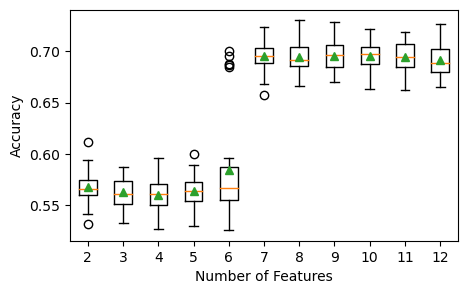

In [30]:
# plot model performance for comparison
fig = plt.figure(figsize = (5, 3))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel("Accuracy")
plt.xlabel("Number of Features") 
plt.style.use('default')
plt.savefig('Model_ACC.png', facecolor='w', transparent=False)

In [31]:
rfe = RFE(estimator=LDA(), n_features_to_select=7)
rfe.fit(X_train, y_train)
col_names = X.columns.tolist()
selected_cols = []
for i in range(X.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (col_names[i], rfe.support_[i], rfe.ranking_[i]))
	if rfe.support_[i]:
		selected_cols.append(col_names[i])

Column: schedule_playoff, Selected True, Rank: 1.000
Column: stadium_neutral, Selected True, Rank: 1.000
Column: weather_temperature, Selected False, Rank: 5.000
Column: weather_wind_mph, Selected False, Rank: 10.000
Column: weather_humidity, Selected False, Rank: 9.000
Column: elo1_pre, Selected False, Rank: 2.000
Column: elo2_pre, Selected False, Rank: 3.000
Column: pred_home_win, Selected True, Rank: 1.000
Column: qbelo1_pre, Selected False, Rank: 8.000
Column: qbelo2_pre, Selected False, Rank: 6.000
Column: pred_homeQB_win, Selected True, Rank: 1.000
Column: home_favorite, Selected True, Rank: 1.000
Column: over_line, Selected True, Rank: 1.000
Column: qb1_relative, Selected True, Rank: 1.000
Column: qb1_pre_relative_value, Selected False, Rank: 4.000
Column: qb1_relative_adj, Selected False, Rank: 7.000


## Implementing & Comparing Various Machine Learning Models
<a class="anchor" id="IMPLEMENT"></a>
Defining functions to tune the feature selection algorithm. Each model that is tested will be evaluated via cross-validation to ensure that the results are not due to chance alone.

### Model Selection and Training
Here we will experiment on three different models: Logistic Regression, Decision Tree, and XGBoost

In [40]:
# Splitting the data into training and test sets once again based on results from RFE algorithm

X = df[selected_cols]
Y = df.result

# Initializing Model Results
model_results = []
model_names = []

In [65]:
LR = LogisticRegression()

# Evaluate the model against the testing data
scores = evaluate_model(LR, X, Y)
model_results.append(scores)
model_names.append("Logistic Regression")
print(scores.mean())

0.755761446111338


In [64]:
DTC = DecisionTreeClassifier()

scores = evaluate_model(DTC, X, Y)
model_results.append(scores)
model_names.append("Decision Tree")
print(scores.mean())

0.6945390228241201


In [43]:
# https://www.datacamp.com/tutorial/xgboost-in-python

import xgboost as xgb
xg_classify = xgb.XGBClassifier(verbosity = 0)

scores = evaluate_model(xg_classify, X, Y)
model_results.append(scores)
model_names.append("XGBoost")
print(scores.mean())

/Users/ethandinh/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ethandinh/miniforge3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ethandinh/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

0.7567718171735449


In [44]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
scores = evaluate_model(RF, X, Y)
model_results.append(scores)
model_names.append("Random Forest")
print(scores.mean())

0.7554382114295721


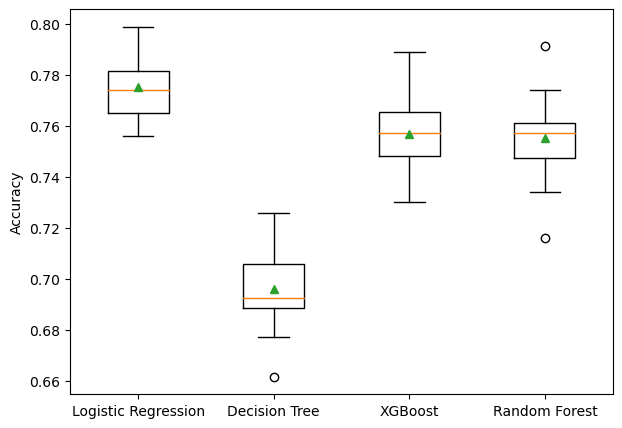

In [45]:
fig = plt.figure(figsize = (7, 5))
plt.boxplot(model_results, labels=model_names, showmeans=True)
plt.ylabel("Accuracy")
plt.style.use('default')
plt.savefig('Model_ACC.png', facecolor='w', transparent=False)

## Hyper Parameter Tuning of The Three Best Models
<a class="anchor" id="TUNE"></a>
We found the three best models to be: Decision Tree, XGBoost, RandomForestClassifier. We will tune these three models using the bayesian optimization algorithm on all games from 1980 to 2018 in hopes that we can accurately predict 2019 games.

In [77]:
train_x = train[selected_cols]
train_y = train.result

test_x = test[selected_cols]
test_y = test.result

In [171]:
# Adopted from https://thinkingneuron.com/how-to-tune-hyperparameters-automatically-using-bayesian-optimization/
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, anneal

RF = RandomForestClassifier()
LR = LogisticRegression()
xg_classify = xgb.XGBClassifier()

# Defining a cost function which the Bayesian algorithm will optimize
def RF_objective(parameter_space):

    Error = 1 - cross_val_score(RF, train_x, train_y, cv = 5, scoring='accuracy').mean()
    return {'loss': Error, 'status': STATUS_OK}

def XGB_objective(parameter_space):
    parameter_space = {
        'max_depth': parameter_space['max_depth'],
        'learning_rate': parameter_space['learning_rate'],
        'n_estimators': parameter_space['n_estimators']
    }
    xg_classify = xgb.XGBClassifier(**parameter_space)
    XGB_error = 1 - cross_val_score(xg_classify, train_x, train_y, cv = 5, scoring='accuracy').mean()
    return {'loss': XGB_error, 'status': STATUS_OK}

In [79]:
RF_parameter_space = { 'n_estimators': hp.quniform('n_estimators',5,50,5),
                       'max_depth': hp.quniform('max_depth', 2,10,1),
                      'criterion': hp.choice('criterion', ['gini', 'entropy'])
                  }
  
# Finding out which set of hyperparameters give highest accuracy
RF_trials = Trials()
RF_best_params = fmin(fn= RF_objective,
            space= RF_parameter_space,
            algo=anneal.suggest, 
            max_evals = 100,
            trials= RF_trials)

print(RF_best_params)

100%|██████████| 100/100 [04:07<00:00,  2.48s/trial, best loss: 0.23808995002776234]
{'criterion': 1, 'max_depth': 4.0, 'n_estimators': 30.0}


<AxesSubplot:xlabel='criterion'>

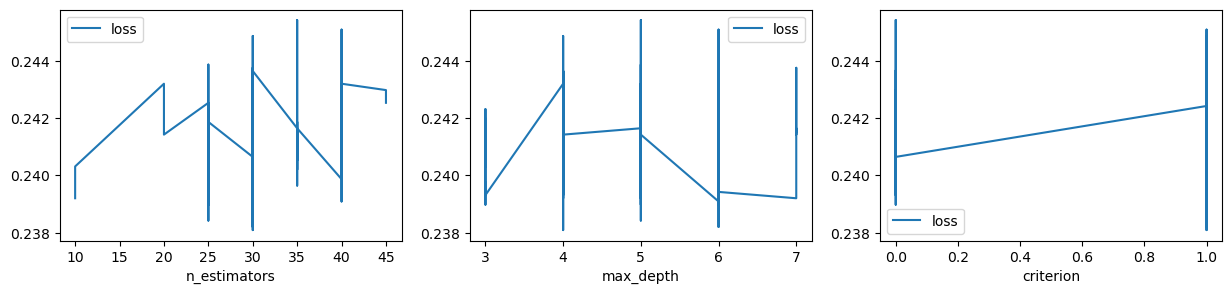

In [80]:
RF_search_results = pd.DataFrame({'loss': RF_trials.losses(), 
                               'n_estimators': RF_trials.vals['n_estimators'],
                               'max_depth': RF_trials.vals['max_depth'],
                               'criterion': RF_trials.vals['criterion']
                               })

fig, subPlots=plt.subplots(nrows=1, ncols=3, figsize=(15,3))
RF_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[0])
RF_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
RF_search_results.sort_values(by='criterion').plot(x='criterion', y='loss', ax=subPlots[2])

We tested the logistic regression model via grid search since the Bayesian Optimization approach seemed to fail.

In [121]:
from sklearn.model_selection import GridSearchCV

space = dict()
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(LR, space, scoring='accuracy', n_jobs=-1, cv=5)
# execute search
LR_result = search.fit(train_x, train_y,)
# summarize result
print('Best Score: %s' % LR_result.best_score_)
print('Best Hyperparameters: %s' % LR_result.best_params_)

Best Score: 0.7747917823431427
Best Hyperparameters: {'C': 0.1}


/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ethandinh/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Text(0, 0.5, 'Accuracy')

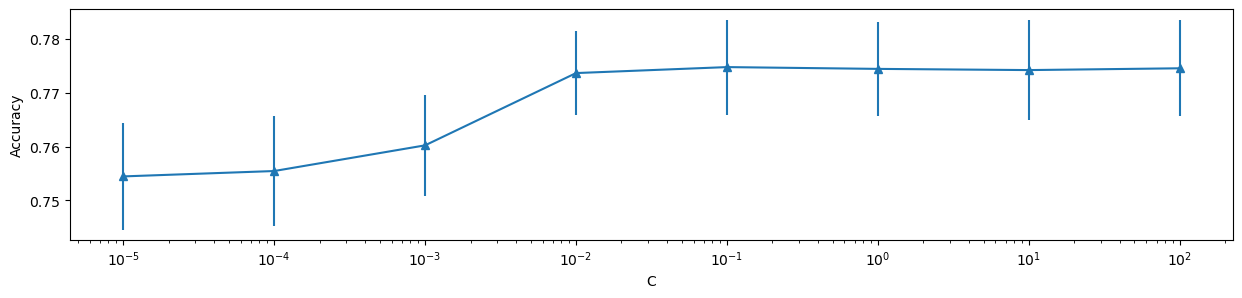

In [130]:
scores = LR_result.cv_results_
means_test = scores["mean_test_score"]
std_test = scores["std_test_score"]
x = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

fig =plt.figure(figsize=(15,3))
plt.errorbar(x, means_test, std_test, marker='^')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")

In [175]:
# Tuning 
XGB_parameter_space = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
    "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
    }

# Finding out which set of hyperparameters give highest accuracy
XGB_trials = Trials()

XGB_best_params = fmin(fn= XGB_objective,
            space= XGB_parameter_space,
            algo=tpe.suggest, 
            max_evals = 100,
            trials= XGB_trials)

print(XGB_best_params)

100%|██████████| 100/100 [1:21:41<00:00, 49.02s/trial, best loss: 0.23053886381880961]
{'learning_rate': 0.12257988949591622, 'max_depth': 0, 'n_estimators': 343}


<AxesSubplot:xlabel='n_estimators'>

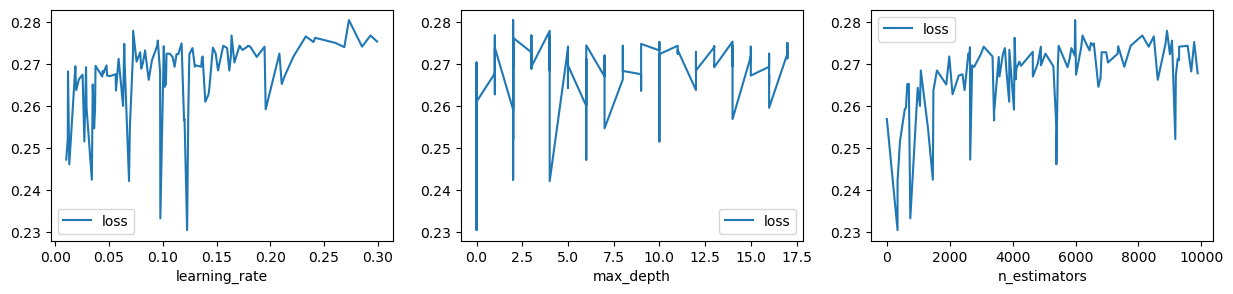

In [176]:
XGB_search_results = pd.DataFrame({'loss': XGB_trials.losses(), 
                               'learning_rate': XGB_trials.vals['learning_rate'],
                               'max_depth': XGB_trials.vals['max_depth'],
                               "n_estimators": XGB_trials.vals['n_estimators']
                               })

fig , subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
XGB_search_results.sort_values(by='learning_rate').plot(x='learning_rate', y='loss', ax=subPlots[0])
XGB_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
XGB_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[2])

Interestingly, tuning the hyperparameters for the XGBoost Classifier model does not affect its loss. As a result, we kept the default parameters in order to minimize the training time for the Calibrated Classifier Model below.

## Extrapolation
<a class="anchor" id="EXTRA"></a>
Using a calibrated classifier model with a voting classifier as its base, we hope to utilize the models we tuned above to predict the games on unseen data from 2019.

In [181]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV as CCV

boost = xgb.XGBClassifier(learning_rate = 0.12257988949591622, n_estimators = 343, verbosity = 0)
RF = RandomForestClassifier(criterion= 'entropy', max_depth = 4, n_estimators = 30)
LR = LogisticRegression(C = 0.1, penalty = 'l2')
vote = VotingClassifier(estimators=[('boost', boost), ('LR', LR), ('RF', RF)], voting='soft')

model = CCV(vote, method='isotonic', cv=3)
model.fit(train_x, train_y)

CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('boost',
                                                                    XGBClassifier(base_score=None,
                                                                                  booster=None,
                                                                                  colsample_bylevel=None,
                                                                                  colsample_bynode=None,
                                                                                  colsample_bytree=None,
                                                                                  enable_categorical=False,
                                                                                  gamma=None,
                                                                                  gpu_id=None,
                                                                                  importance_type=None,
           

In [182]:
predicted = model.predict_proba(test_x)[:,1]

In [183]:
test.loc[:,'hm_won_prob'] = predicted
test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'hm_won_prob', 'result']]

test['my_bet_won'] = (((test.hm_won_prob >= 0.60) & (test.result == 1)) | ((test.hm_won_prob <= 0.40) & (test.result == 0))).astype(int)
test['my_bet_lost'] = (((test.hm_won_prob >= 0.60) & (test.result == 0)) | ((test.hm_won_prob <= 0.40) & (test.result == 1))).astype(int)

In [184]:
# printing some quick overall results for my model
print("Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

Model Win Percentage: 0.8182
Total Number of Bets Won: 162
Total Number of Bets Made: 198
Possible Games: 251
